# Data Preparation (1a, 1b)

In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import random
import numpy as np
import torch
import re
# import nltk
# nltk.download("stopwords")
# nltk.download("wordnet")
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from transformers import BertTokenizer, BertModel

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
rootpath = "./"

TRAIN_STANCES_CSV = f"{rootpath}./fnc-1/train_stances.csv"
TRAIN_BODIES_CSV = f"{rootpath}./fnc-1/train_bodies.csv"
TEST_STANCES_CSV = f"{rootpath}./fnc-1/competition_test_stances.csv"
TEST_BODIES_CSV = f"{rootpath}./fnc-1/competition_test_bodies.csv"

RELATED_DICT = {"agree":1, "disagree":1, "discuss":1, "unrelated":0}
STANCE_DICT = {"agree":0, "disagree":1, "discuss":2, "unrelated":3}

STOP = set(stopwords.words('english'))
LEM = WordNetLemmatizer()

TFIDF_TOKENIZER = TfidfVectorizer(strip_accents="unicode", decode_error="ignore", lowercase=True, min_df=0.01)
SVD = TruncatedSVD(n_components=300, algorithm="arpack", random_state=42)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# BERT = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)
# TOKENIZER = BertTokenizer.from_pretrained('bert-base-uncased')
# BERT.eval()
# BERT.to(DEVICE)

def get_tfidf_embedding(x, fit):
    print(x.shape)
    x = TFIDF_TOKENIZER.fit_transform(x) if fit else TFIDF_TOKENIZER.transform(x)
    x = SVD.fit_transform(x) if fit else SVD.transform(x)
    return x

def clip_pad_tokens(t, max_size):
    t = t[:max_size]
    num_pad = max_size - len(t)
    if num_pad > 0:
        t += ["[PAD]"] * num_pad
    return t, num_pad

def tokenize_text(head, body):
    head = "[CLS] " + head
    tokens1 = TOKENIZER.tokenize(head)
    tokens1, num_pad = clip_pad_tokens(tokens1, 23)
    tokens1 += ["[SEP]"]
    attention_mask1 = [1] * (len(tokens1) - num_pad - 1) + [0] * num_pad + [1]
    tokens2 = TOKENIZER.tokenize(body)
    tokens2, num_pad = clip_pad_tokens(tokens2, 488)
    attention_mask2 = [1] * (len(tokens2) - num_pad) + [0] * num_pad
    input_ids = TOKENIZER.convert_tokens_to_ids(tokens1 + tokens2)
    token_type_ids = [0] * len(tokens1) + [1] * len(tokens2)
    attention_mask = attention_mask1 + attention_mask2
    # return torch.tensor(input_ids)[None, :], \
    #     torch.tensor(token_type_ids)[None, :], \
    #     torch.tensor(attention_mask)[None, :]
    return torch.tensor(input_ids, device=DEVICE)[None, :], \
        torch.tensor(token_type_ids, device=DEVICE)[None, :], \
        torch.tensor(attention_mask, device=DEVICE)[None, :]

def get_bert_embedding(x, path="embeddings_bert"):
    len_x = len(x) // 2
    embedding_lst = []
    for i in range(len_x):
        input_ids, token_type_ids, attention_mask = tokenize_text(x[i], x[i + len_x])
        with torch.no_grad():
            output_layers = BERT(input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)[2]
        # embedding = torch.cat([output_layers[-4], output_layers[-3], output_layers[-2], output_layers[-1]], dim=1).squeeze()
        embedding = (output_layers[-4] + output_layers[-3] + output_layers[-2] + output_layers[-1]).squeeze()
        embedding_lst.append(embedding)
        # embedding_lst.append(torch.mean(embedding, dim=0))
        if i > 0 and i % 1000 == 0:
            print("Getting it done, bossman.")
        if i == len_x - 1:
            torch.save(torch.stack(embedding_lst), f"{rootpath}/embeddings/{path}.pt")
    return torch.stack(embedding_lst)

def clean_text(t):
    t = re.sub(r"[^\w\s*]", " ", t.lower())
    lst = [word for word in t.split() if word not in STOP]
    lst = [LEM.lemmatize(word) for word in lst]
    t = " ".join(lst)
    return t

def clean_data(data):
    data["headline_clean"] = data["headline"].apply(lambda x: clean_text(x))
    data["body_clean"] = data["body"].apply(lambda x: clean_text(x))
    return data

def get_data(use_tfidf, train_data=True, use_artificial_data=True):
    data = load_data(train_data=train_data, use_artificial_data=use_artificial_data)
    if use_tfidf:
        data = clean_data(data)
        x = pd.concat([data["headline_clean"], data["body_clean"]]).to_numpy().squeeze().astype("U")
        x = get_tfidf_embedding(x, data)
        x = np.concatenate([x[:x.shape[0]//2, :], x[x.shape[0]//2:, :]], axis=1)
    else:
        x = pd.concat([data["headline"], data["body"]]).to_numpy().squeeze().astype("U")
        x = get_bert_embedding(x)
    return x, data["related"].to_numpy(), data["stance"].to_numpy()

def load_data(train_data=True, use_artificial_data=True):
    stances = pd.read_csv(TRAIN_STANCES_CSV) if train_data else pd.read_csv(TEST_STANCES_CSV)
    bodies = pd.read_csv(TRAIN_BODIES_CSV) if train_data else pd.read_csv(TEST_BODIES_CSV)
    data = pd.merge(stances, bodies, how="outer", on="Body ID").drop("Body ID", axis=1)
    data.rename(columns={"articleBody":"body", "Headline":"headline", "Stance":"stance"}, inplace=True)
    y = data.drop(["body", "headline"], axis=1).to_numpy().squeeze().astype("U")
    y_related = np.vectorize(RELATED_DICT.get)(y)
    y_stance =  np.vectorize(STANCE_DICT.get)(y)
    data = data.drop(["stance"], axis=1)
    data["related"] = y_related
    data["stance"] = y_stance
    if train_data and use_artificial_data:
        artificial_data = pd.read_csv(f"{rootpath}./data/artificial_data.csv", index_col=0)
        data = pd.concat([data, artificial_data])
    return data

We augment the data using the translate function from TextBlob to address the imablance problem. We randomly sample a related item, translate the item to a random language, and then translate the item back to English. Source: https://towardsdatascience.com/how-i-handled-imbalanced-text-data-ba9b757ab1d8

In [83]:
train_data = load_data(use_artificial_data=False)
train_data = clean_data(train_data)
artificial_train_data = load_data()
artificial_train_data = clean_data(artificial_train_data)
test_data = load_data(train_data=False)

In [ ]:
x1_train, y1_train_related, y1_train_stance = get_data(use_tfidf=True, train_data=True, use_artificial_data=True)
del x1_train, y1_train_related, y1_train_stance
x1_test, y1_test_related, y1_test_stance = get_data(use_tfidf=True, train_data=False)

In [ ]:
x2_train, y2_related, y2_stance = get_data(use_tfidf=False, train_data=True, use_artificial_data=True)
x2_test, y2_test, y2_test = get_data(use_tfidf=False, train_data=False)

In [85]:
# np.savez(f"{rootpath}./embeddings/embeddings_tfidf", x1_train, y1_train_related, y1_train_stance)
np.savez(f"{rootpath}./embeddings/embeddings_artificial_tfidf", x1_train, y1_train_related, y1_train_stance)

# Data Exploration

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud
from collections import defaultdict
import math

In [75]:
def std(lst, mean):
    return math.sqrt(sum([(x - mean)**2 for x in lst]) / len(lst))

def explore_data(data):
    max_title_length = float("-inf")
    min_title_length = float("inf")
    total_title_length = 0
    title_lengths = []
    max_body_length = float("-inf")
    min_body_length = float("inf")
    total_body_length = 0
    body_lengths = []
    tokenised_title_length = []
    for _, row in data.iterrows():
        if max_title_length < len(row[0].split()):
            max_title_length = len(row[0].split())
        if min_title_length > len(row[0].split()):
            min_title_length = len(row[0].split())
        if max_body_length < len(row[1].split()):
            max_body_length = len(row[1].split())
        if min_body_length > len(row[1].split()):
            min_body_length = len(row[1].split())
        total_title_length += len(row[0].split())
        title_lengths.append(len(row[0].split()))
        total_body_length += len(row[1].split())
        body_lengths.append(len(row[1].split()))
        temp = "[CLS] " + row[0]
        tokenised_title_length.append(len(TOKENIZER.tokenize(temp)))

    avg_title_length = total_title_length / data.shape[0]
    std_title_length = std(title_lengths, avg_title_length)
    avg_body_length = total_body_length / data.shape[0]
    std_body_length = std(body_lengths, avg_body_length)
    avg_tokenised_title_length = sum(tokenised_title_length) / len(tokenised_title_length)
    std_tokenised_title_length = std(tokenised_title_length, avg_tokenised_title_length)
    print(f"Dataset size: {data.shape[0]}")
    print(f"Unrelated/Related instances:")
    print(data['related'].value_counts(normalize=True))
    print(f"Unrelated/Discuss/Agree/Disagree instances:")
    print(data['stance'].value_counts(normalize=True))
    print(f"max_title_length: {max_title_length}")
    print(f"min_title_length: {min_title_length}")
    print(f"avg_title_length: {avg_title_length:.2f} \t std: {std_title_length}")
    print(f"max_body_length: {max_body_length}")
    print(f"min_body_length: {min_body_length}")
    print(f"avg_body_length: {avg_body_length:.2f} \t std: {std_body_length}")
    print(f"avg_tokenised_title_length: {avg_tokenised_title_length:.2f} \t std: {std_tokenised_title_length}")

In [76]:
explore_data(train_data)

Dataset size: 49972
Unrelated/Related instances:
0    0.73131
1    0.26869
Name: related, dtype: float64
Unrelated/Discuss/Agree/Disagree instances:
3    0.731310
2    0.178280
0    0.073601
1    0.016809
Name: stance, dtype: float64
max_title_length: 40
min_title_length: 2
avg_title_length: 11.13 	 std: 4.201754483868212
max_body_length: 4788
min_body_length: 4
avg_body_length: 369.70 	 std: 279.69250454211857
avg_tokenised_title_length: 15.68 	 std: 5.822767743213386


In [86]:
explore_data(artificial_train_data)

Dataset size: 61590
Unrelated/Related instances:
0    0.593359
1    0.406641
Name: related, dtype: float64
Unrelated/Discuss/Agree/Disagree instances:
3    0.593359
2    0.270369
0    0.111788
1    0.024484
Name: stance, dtype: float64
max_title_length: 52
min_title_length: 1
avg_title_length: 11.23 	 std: 4.282686283246218
max_body_length: 4788
min_body_length: 1
avg_body_length: 364.82 	 std: 279.8594379076085
avg_tokenised_title_length: 15.66 	 std: 5.816883961817943


In [95]:
# # visualize the data on a WordCloud
# def visualize(col_name):
#     words = ''
#     for msg in train_data[col_name]:
#         msg = msg.lower()
#         words += msg + ' '
#     wordcloud = WordCloud(width=600, height=600).generate(words)
#     plt.imshow(wordcloud)
#     plt.axis('off')
#     plt.show()

# visualize("articleBody")
# visualize("Headline")

In [16]:
def plot_top_n_words(label, plot_stop=False, headline_index=0, body_index=1):
    corpus = []
    for _, row in train_data[train_data['stance'] == label].iterrows():
        lst = row[headline_index].split()
        lst += row[body_index].split()
        for w in lst:
            corpus.append(w)
    
    corpus_dict = defaultdict(int)
    for word in corpus:
        if plot_stop and word in STOP:
            corpus_dict[word] += 1
        elif not plot_stop and word not in STOP:
            corpus_dict[word] += 1
    top_n = 10
    top = sorted(corpus_dict.items(), key=lambda x: x[1], reverse=True)[:top_n]
    x, y = zip(*top)
    plt.figure(figsize=(7,5))
    plt.title(label)
    plt.bar(x, y)
    plt.show()

In [ ]:
plot_top_n_words(0)
plot_top_n_words(1)
plot_top_n_words(2)
plot_top_n_words(3)
plot_top_n_words(0, headline_index=4, body_index=5)
plot_top_n_words(1, headline_index=4, body_index=5)
plot_top_n_words(2, headline_index=4, body_index=5)
plot_top_n_words(3, headline_index=4, body_index=5)

# Data Augmentation

In [3]:
train_data = pd.read_csv("./data/augmented_data.csv")
print(f"Dataset size: {train_data.shape[0]}")
print(f"Unrelated/Related instances:")
print(train_data['related'].value_counts(normalize=True))
print(f"Unrelated/Discuss/Agree/Disagree instances:")
print(train_data['stance'].value_counts(normalize=True))

Dataset size: 51363
Unrelated/Related instances:
0.0    0.73131
1.0    0.26869
Name: related, dtype: float64
Unrelated/Discuss/Agree/Disagree instances:
3.0    0.731310
2.0    0.178280
0.0    0.073601
1.0    0.016809
Name: stance, dtype: float64


# Evaluation Metrics

In [8]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sn
import pickle

In [9]:
def plot_roc_curve(y_test, y_pred):
    ''' Plot the ROC curve for the target labels and predictions'''
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    roc_auc= auc(fpr,tpr)
    plt.figure(figsize=(12, 12))
    ax = plt.subplot(121)
    ax.set_aspect(1)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [10]:
def plot_confussion_matrix(y_test, y_pred):
    ''' Plot the confussion matrix for the target labels and predictions '''
    cm = confusion_matrix(y_test, y_pred)

    # Create a dataframe with the confussion matrix values
    df_cm = pd.DataFrame(cm, range(cm.shape[0]),
                  range(cm.shape[1]))

    # Plot the confussion matrix
    sn.set(font_scale=1.4) #for label size
    sn.heatmap(df_cm, annot=True,fmt='.0f',cmap="YlGnBu",annot_kws={"size": 10})# font size
    plt.show()

# C-Support Vector Classification (2a Part I)

### TF-IDF Embedding (without artificial data)

              precision    recall  f1-score   support

           0       0.85      0.71      0.77     18349
           1       0.47      0.67      0.55      7064

    accuracy                           0.70     25413
   macro avg       0.66      0.69      0.66     25413
weighted avg       0.74      0.70      0.71     25413



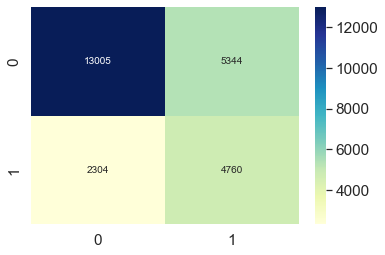

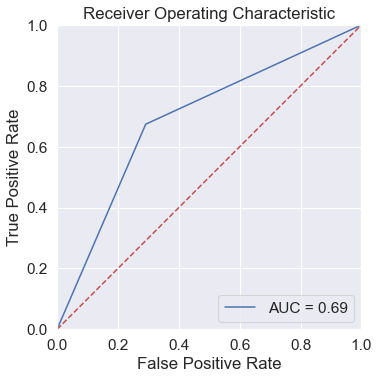

In [95]:
model = pickle.load(open("svc_tfidf.sav", "rb"))
y_pred = model.predict(x1_test)

print(metrics.classification_report(y1_test_related, y_pred))
plot_confussion_matrix(y1_test_related, y_pred)
plot_roc_curve(y1_test_related, y_pred)

### TF-IDF Embedding (with artificial data)

              precision    recall  f1-score   support

           0       0.97      0.32      0.48     18349
           1       0.35      0.97      0.52      7064

    accuracy                           0.50     25413
   macro avg       0.66      0.64      0.50     25413
weighted avg       0.80      0.50      0.49     25413



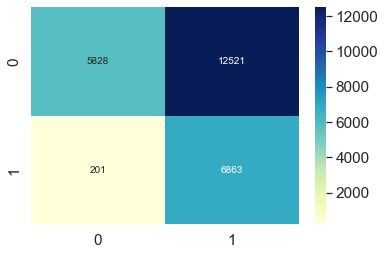

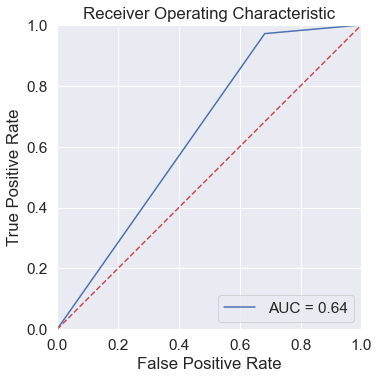

In [94]:
model = pickle.load(open("./svc_tfidf_artificial_data.sav", "rb"))
y_pred = model.predict(x1_test)

print(metrics.classification_report(y1_test_related, y_pred))
plot_confussion_matrix(y1_test_related, y_pred)
plot_roc_curve(y1_test_related, y_pred)

### Bert Embedding

# Convolutional Neural Network (2a Part II)

In [38]:
def format_labels(y):
    return torch.cat([1-y, y], dim=1)

def reformat_labels(y):
    y[:, 0] = 0
    y[:, 0] += y[:, 1]
    return y[:, 0]

tensor([1, 0, 0])

### TF-IDF Embedding (Equal class weights)

              precision    recall  f1-score   support

           0       0.96      0.29      0.45     18349
           1       0.34      0.97      0.51      7064

    accuracy                           0.48     25413
   macro avg       0.65      0.63      0.48     25413
weighted avg       0.79      0.48      0.47     25413



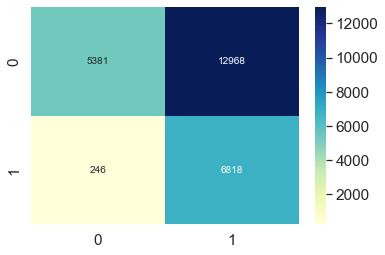

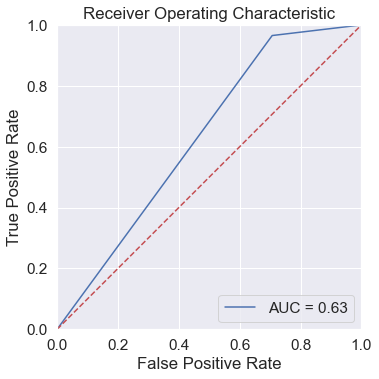

In [80]:
from cnn import CNN_TFIDF

c3 = [2, 2, 4, 8, 16]
k2 = [3, 3, 3, 3]

model = CNN_TFIDF(channels=c3, kernel_sizes=k2)
model.load_state_dict(torch.load(f"{rootpath}./cnn_tfidf.pt"))
y_pred = model(torch.tensor(x1_test, dtype=torch.float))
y_pred = torch.argmax(y_pred, dim=1)

y_pred = y_pred.detach().numpy()

print(metrics.classification_report(y1_test_related, y_pred))
plot_confussion_matrix(y1_test_related, y_pred)
plot_roc_curve(y1_test_related, y_pred)

### TF-IDF Embedding (Unequal Class Weights)

In [34]:
from cnn import CNN_TFIDF

c3 = [2, 2, 4, 8, 16]
k2 = [3, 3, 3, 3]

model = CNN_TFIDF(channels=c3, kernel_sizes=k2)
model.load_state_dict(torch.load("./cnn_tfidf_art.pt"))
y_pred = model(torch.tensor(x1_test, dtype=torch.float))
y_pred = torch.argmax(y_pred, dim=1)

y_pred = y_pred.detach().numpy()

print(metrics.classification_report(y1_test_related, y_pred))
plot_confussion_matrix(y1_test_related, y_pred)
plot_roc_curve(y1_test_related, y_pred)

              precision    recall  f1-score   support

         0.0       0.97      0.46      0.62     18349
         1.0       0.41      0.97      0.57      7064

    accuracy                           0.60     25413
   macro avg       0.69      0.71      0.60     25413
weighted avg       0.81      0.60      0.61     25413



### Bert Embedding

In [36]:
from cnn import CNN_Bert

c1 = [24, 24, 32, 48, 64]
c2 = [488, 488, 248, 124, 64]
k1 = [3, 3, 3, 3]
m1 = 4

model = CNN_Bert(channel_head=c1, channels_body=c2, kernel_sizes=k1)
model.load_state_dict(torch.load("./cnn_bert.pt"))
y_pred = model(torch.tensor(x2_test, dtype=torch.float))
y_pred = torch.argmax(y_pred, dim=1)

y_pred = y_pred.detach().numpy()

print(metrics.classification_report(y1_test_related, y_pred))
plot_confussion_matrix(y1_test_related, y_pred)
plot_roc_curve(y1_test_related, y_pred)

              precision    recall  f1-score   support

         0.0       0.98      0.68      0.80     18349
         1.0       0.53      0.97      0.69      7064

    accuracy                           0.76     25413
   macro avg       0.76      0.82      0.74     25413
weighted avg       0.86      0.76      0.77     25413

